In [123]:
# 필요한 모듈

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac29/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 뉴스 데이터 수집 <br><br>

터미널을 통해 csv 파일 다운로드 <br>
```
wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv
```

아래의 파이썬 코드를 통해 현재 작업중인 폴더에 csv 데이터 다운로드 <br>
``` python
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
```


In [124]:
# 데이터 불러오기

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")

print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [125]:
# 데이터 샘플 확인

"""
'text', 'headlines' 두 개의 칼럼으로 구성
Abstractive Summarization 의 경우 : text를 본문, headlines를 요약문 데이터로 사용
Extractive Summarization 의 경우 : text를 본문으로 하나만 데이터로 사용
"""

data.sample(10)

,headlines,text
60309,Johar not compelled to cast him: Ishaan's fath...,"Ishaan Khatter's father actor Rajesh Khattar, ..."
40755,"Facebook to reduce Android call history, SMS d...",Technology giant Facebook has announced that t...
62462,Certainly open to meet North Korean leader Jon...,US President Donald Trump has said that he is ...
31754,Youth causes boy's death by inserting pipe in ...,A Ludhiana court on Wednesday sentenced a yout...
74430,MP Hindu outfit proposes Aadhaar for entry to ...,The Hindu Utsav Samiti (HUS) in Madhya Pradesh...
33558,Tesla shareholders to vote on removing Musk as...,Tesla shareholder Jing Zhao has proposed its b...
86189,Dying to show to mom: Johar on father's pic wi...,Filmmaker Karan Johar tweeted that he's dying ...
7871,"1 dead, 19 admitted post fire in Mumbai's 18-s...",A 70-year-old woman died and 19 were hospitali...
34941,PM Modi meets Queen Elizabeth II during UK visit,PM Narendra Modi on Wednesday met Queen Elizab...
74877,Trump's top aide contradicts his position on N...,There is no military solution to North Korean ...


<br>

## 데이터 전처리 <br><br>

전처리로 텍스트를 정규화 또는 정제. <br>
( 불용어를 제거할 경우, 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민 )

<br>

<br>

### 중복 및 NULL 값이 존재하는 샘플 제거 <br><br>

혹여나 있을 수 있는 중복 데이터와 null 데이터 샘플 제거

<br>

In [126]:
# 데이터의 중복 샘플 유무를 확인

print('text 열에서 중복을 배제한 유일한(unique) 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한(unique) 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한(unique) 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한(unique) 샘플의 수 : 98280


In [127]:
# 데이터프레임의 drop_duplicates()를 사용하여, 중복 샘플 제거

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


<br>

### 텍스트 정규화와 불용어 제거

- __텍스트 정규화 (text normalization)__ <br>
같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우. <br>
( 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄임 ) <br><br>
ex. it'll == it will <br>
ex. haven't == have not <br><br>
[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python) <br><br>

- __불용어(stopwords) 제거__ <br>
때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있습니다. <br>
( NLTK에서 제공하는 불용어 179 개의 리스트를 참조해, 샘플에서 불용어를 제거 ) <br><br>
데이터프레임의 두 컬럼 'Text'와 'Summary' 중에서 'Text'에 대해서만 불용어 제거 <br>
( __Abstractive__한 문장요약 결과를 위해 'Summary'에는 불용어가 남아 있는게 더 자연스러움 )

<br>

In [128]:
# 텍스트 정규화를 위한 사전(dictionary) 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


<br>

### 기타 전처리

- 영어문자 소문자화
- html 태그 제거
- 정규표현식으로 특수문자 제거

<br>

In [129]:
# 데이터 전처리 함수 작성

def preprocess_sentence(sentence, remove_stopwords=True):

    # 텍스트 소문자화
    sentence = sentence.lower()
    # html 태그 제거  <br />, <a href = ...> 등
    sentence = BeautifulSoup(sentence, "lxml").text
    # 괄호로 닫힌 문자열 (...) 제거  ex) my husband (and myself!) for -> my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    # 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence)
    # 약어 정규화 (위에서 생성한 정규화사전 이용)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","",sentence)
    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    # m이 3개 이상이면 2개로 변경. ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 ('text')
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 ('headlines')
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [130]:
# 전처리 함수 확인

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 'headlines' 칼럼은 불용어를 미제거

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


<br>

### 훈련 데이터 전체에 대해 전처리 수행

Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행

<br>

In [131]:
# 'text' 칼럼의 데이터 전처리 (불용어 제거)

clean_text = []

# 'text' 칼럼 전체 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [132]:
# 'headlines' 칼럼의 데이터 전처리 (불용어 안 제거)

clean_headlines = []

# 소문자화 위해 astype(str)으로 데이터프레임 string화
new_data = data.astype(str)

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in new_data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

<br>

### 전처리 후 빈(empty) 샘플 재확인 후, NULL 값 제거 <br><br>

텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋습니다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있습니다.

<br>

In [133]:
# 전처리한 데이터를 데이터프레임에 저장 후, 빈(empty) 값을 가진 샘플을 모두 Null 값으로 대체

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [134]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [135]:
# Null 샘플 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


<br>

## 학습을 위한 데이터 준비(처리) <br><br>

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, <br>
문장의 시작(SOS) 과 끝(EOS) 을 표시 해줘야합니다. <br>
그 후에 train / test 데이터 세트를 나누어 줍니다.

<br>

<br>

### 샘플의 최대 길이 정하기 <br><br>

학습(train)에 사용할 샘플의 최대 길이 결정 <br><br><br>


### 텍스트 길이에 따른 데이터(개수) 분포 시각화 <br><br>

적절한 최대길이를 결정하기 위해, <br>
'text'와 'headlines'의 최소, 최대, 평균 길이를 구하고, 각각의 길에 대한 분포를 시각화하여 관찰해 봅시다. <br><br>

많은 양의 데이터를 다룰때는 데이터를 시각화하여 보는 것이 도움이 됩니다. <br>
'headlines', 'text' 각각에 대해 텍스트 길이 분포 박스플롯과 길이별 개수 분포의 막대플롯을 그려서 텍스트 길이별 데이터 분포를 확인.

<br>

headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534
text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221


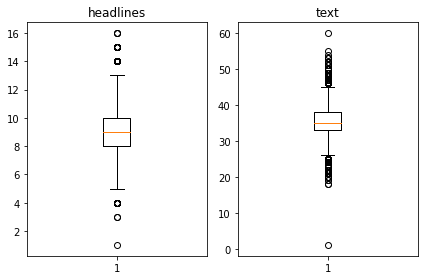

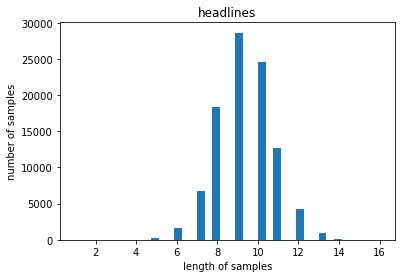

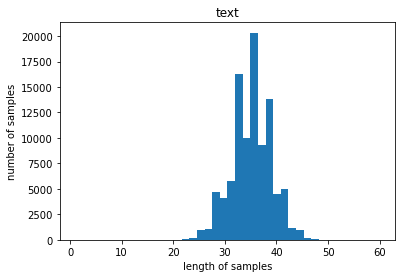

In [136]:
# 'text'와 'headlines'의 최소, 최대, 평균 길이를 구하고, 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

headlines의 최소 길이 : 1 <br>
headlines의 최대 길이 : 16 <br>
headlines의 평균 길이 : 9 <br>
text의 최소 길이 : 1 <br>
text의 최대 길이 : 60 <br>
text의 평균 길이 : 35 <br><br>

위 결과를 바탕으로 'text' 와 'headlines' 각각 학습(train)에 사용할 샘플의 최대 길이 결정

<br>

In [137]:
# 'text' 최대길이 45, 'headlines' 최대길이 13 로 임의설정

text_max_len = 45
headlines_max_len = 13

text_min_len = 25
headlines_min_len = 5

<br>

### 최대길이에서 제외되는 데이터 샘플 통계적으로 확인 <br><br>

각각 45와 13으로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 __통계__로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 됩니다. <br><br>

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해봅시다. <br>
아래와 같은 함수를 통해 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있습니다.

<br>

In [138]:
# 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인

# 몇 퍼센트의 샘플까지 포함하는지 확인하는 함수 생성
def below_threshold_len(min_len, max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(min_len <= len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상 %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))

# 'text'와 'headlines'에 대해 확인
below_threshold_len(text_min_len, text_max_len, data['text'])
below_threshold_len(headlines_min_len, headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 25 이상 45 이하인 샘플의 비율: 0.994408296055307
전체 샘플 중 길이가 5 이상 13 이하인 샘플의 비율: 0.9979971533143555


In [139]:
# 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97863


<br>

## 시작 토큰과 종료 토큰 추가

디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추게 됩니다. <br><br>

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 합니다. <br><br>

시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가 <br>
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, <br>
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target <br>
이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들거에요.

<br>

In [140]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [141]:
# 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장

# 인코더의 입력
encoder_input = np.array(data['text'])
# 디코더의 입력
decoder_input = np.array(data['decoder_input'])
# 디코더의 레이블
decoder_target = np.array(data['decoder_target'])

<br>

### Train / Test dataset 분리

여기에서는 scikit-learn 같은 패키지를 사용하지 않고, <br>
직접 코딩을 통해 학습데이터셋과 테스트데이터셋을 분리해 봅시다.

<br>

In [155]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print(indices)

[41325 49346 83148 ...  2236  9651 94784]


In [156]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 생성됨

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [157]:
# 잘 섞인 데이터를 8:2 비율로 훈련 데이터셋과 테스트 데이터셋으로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


In [177]:
# 이렇게 정의한 테스트 데이터의 갯수를 이용해 전체 데이터를 양분
# :표시의 위치에 주의

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


<br>

## 정수 인코딩 <br><br>


### 단어 집합(vocaburary) 만들기 및 정수 인코딩 <br><br>

__정수 인코딩__ <br>
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변경. <br><br>

__단어 사전__ <br>
이를 위해 {단어:인덱스} 형태로 데이터를 매핑하는 "__단어사전(vocaburary)__" 생성 작업이 필요.

<br>

<br>

#### 훈련 데이터에 대해서 단어 집합 생성

우선, 원문에 해당되는 encoder_input_train에 대해서 단어 사전을 생성합니다. <br>
Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 사전을 만들 수 있습니다.

<br>

In [178]:
# Keras 의 tokenizer 사용하여 학습 데이터에 대한 단어 사전 생성
# 생성된 단어 집합은 src_tokenizer.word_index에 저장

# 토크나이저 정의
src_tokenizer = Tokenizer()
# 입력된 데이터로부터 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train)

<br>

#### 빈도수 낮은 단어 제외

모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행 <br><br>

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보 확인할 수 있습니다.

<br>

In [179]:
# 빈도수가 낮은 단어가 배제될 경우 요약문의 핵심정보를 담는 어휘가 빠질 수 있다고 생각하여 해당 코드는 주석처리하여 실행하지 않았습니다.

# 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()로 단어사전에 대한 통계적 정보 확인

"""
threshold = 3
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
"""

'\nthreshold = 3\ntotal_cnt = len(src_tokenizer.word_index) # 단어의 수\nrare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트\ntotal_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합\nrare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합\n\n# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.\nfor key, value in src_tokenizer.word_counts.items():\n    total_freq = total_freq + value\n\n    # 단어의 등장 빈도수가 threshold보다 작으면\n    if(value < threshold):\n        rare_cnt = rare_cnt + 1\n        rare_freq = rare_freq + value\n\nprint(\'단어 집합(vocabulary)의 크기 :\',total_cnt)\nprint(\'등장 빈도가 %s번 이하인 희귀 단어의 수: %s\'%(threshold - 1, rare_cnt))\nprint(\'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s\'%(total_cnt - rare_cnt))\nprint("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)\nprint("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)\n'

<br>

### 정수 인코딩

<br>

In [183]:
src_vocab = 78000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [184]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[45, 1716, 44498, 72, 1513, 89, 3, 397, 366, 780, 3638, 78, 890, 7885, 5923, 1707, 45, 114, 167, 3, 13, 631, 355, 135, 635, 45, 1163, 341, 674, 29, 3, 3851, 286, 114, 403], [168, 853, 5, 6865, 1244, 34710, 15288, 14215, 2763, 465, 3678, 15900, 3572, 666, 10727, 14712, 1999, 944, 34711, 34712, 14215, 98, 24, 34712, 14215, 44, 44499, 4588, 5800, 137, 1569, 1542, 2083, 2183, 1542, 208], [163, 20, 715, 554, 5175, 857, 27, 3185, 3531, 75, 730, 466, 841, 1196, 5271, 1201, 129, 9112, 554, 5034, 17, 958, 21, 6502, 730, 4378, 349, 114, 958, 3573, 21, 405, 1044, 7761, 300, 235, 730, 4378]]


In [185]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [186]:
# 빈도수가 낮은 단어가 배제될 경우 요약문의 핵심정보를 담는 어휘가 빠질 수 있다고 생각하여 해당 코드는 주석처리하여 실행하지 않았습니다.

"""
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
"""

'\nthreshold = 6\ntotal_cnt = len(tar_tokenizer.word_index) # 단어의 수\nrare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트\ntotal_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합\nrare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합\n\n# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.\nfor key, value in tar_tokenizer.word_counts.items():\n    total_freq = total_freq + value\n\n    # 단어의 등장 빈도수가 threshold보다 작으면\n    if(value < threshold):\n        rare_cnt = rare_cnt + 1\n        rare_freq = rare_freq + value\n\nprint(\'단어 집합(vocabulary)의 크기 :\',total_cnt)\nprint(\'등장 빈도가 %s번 이하인 희귀 단어의 수: %s\'%(threshold - 1, rare_cnt))\nprint(\'단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s\'%(total_cnt - rare_cnt))\nprint("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)\nprint("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)\n'

In [187]:
tar_vocab = 19000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 581, 56, 951, 2524, 3, 13066, 4127, 7638, 2470], [1, 7639, 571, 2525, 37, 2906, 3163, 30, 2526], [1, 55, 1228, 17, 1005, 1258, 6, 483, 4, 37, 3164], [1, 345, 185, 17, 2155, 71, 1221, 4, 8729, 180, 3, 142, 1038], [1, 28, 428, 109, 24, 10, 10407, 259, 447, 225]]
target
decoder  [[581, 56, 951, 2524, 3, 13066, 4127, 7638, 2470, 2], [7639, 571, 2525, 37, 2906, 3163, 30, 2526, 2], [55, 1228, 17, 1005, 1258, 6, 483, 4, 37, 3164, 2], [345, 185, 17, 2155, 71, 1221, 4, 8729, 180, 3, 142, 1038, 2], [28, 428, 109, 24, 10, 10407, 259, 447, 225, 2]]


In [188]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


<br>

### 패딩

서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 <br>
최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 통일

<br>

In [189]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

<br>

## 모델 설계

<br>

<br>

### 인코더 설계

함수형 API를 이용해서 인코더를 설계

<br>

In [190]:
# 함수형 API 이용해서 인코더 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

<br>

### 디코더 설계

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일합니다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 합니다.

<br>

In [191]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

<br>

#### 디코더의 출력층 설계

<br>

In [192]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 128)      9984000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 45, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

<br>

## 어텐션 매커니즘

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻입니다. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 살펴봅시다.

<br>

In [193]:
# 깃허브에 공개되어져 있는 어텐션 함수를 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

<br>

#### 디코더 출력층 수정

<br>

In [194]:
# 어텐션 메커니즘 적용위해 디코더 출력층 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 128)      9984000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 45, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

<br>

## 모델 훈련

<br>

In [195]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 20)

Epoch 1/20
306/306 [==============================] - 168s 549ms/step - loss: 5.6245 - val_loss: 5.1915
Epoch 2/20
306/306 [==============================] - 165s 539ms/step - loss: 5.0800 - val_loss: 4.8269
Epoch 3/20
306/306 [==============================] - 166s 541ms/step - loss: 4.7182 - val_loss: 4.5507
Epoch 4/20
306/306 [==============================] - 166s 541ms/step - loss: 4.4568 - val_loss: 4.3678
Epoch 5/20
306/306 [==============================] - 166s 542ms/step - loss: 4.2555 - val_loss: 4.2287
Epoch 6/20
306/306 [==============================] - 166s 543ms/step - loss: 4.0862 - val_loss: 4.1290
Epoch 7/20
306/306 [==============================] - 166s 544ms/step - loss: 3.9436 - val_loss: 4.0393
Epoch 8/20
306/306 [==============================] - 166s 543ms/step - loss: 3.8190 - val_loss: 3.9561
Epoch 9/20
306/306 [==============================] - 167s 545ms/step - loss: 3.7096 - val_loss: 3.9117
Epoch 10/20
306/306 [==============================] - 166s 543m

In [199]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 20)

Epoch 1/20
306/306 [==============================] - 171s 558ms/step - loss: 2.9839 - val_loss: 3.6440
Epoch 2/20
306/306 [==============================] - 169s 552ms/step - loss: 2.9435 - val_loss: 3.6427
Epoch 3/20
306/306 [==============================] - 168s 551ms/step - loss: 2.9067 - val_loss: 3.6358
Epoch 4/20
306/306 [==============================] - 169s 553ms/step - loss: 2.8726 - val_loss: 3.6279
Epoch 5/20
306/306 [==============================] - 169s 554ms/step - loss: 2.8416 - val_loss: 3.6300
Epoch 6/20
306/306 [==============================] - 170s 556ms/step - loss: 2.8124 - val_loss: 3.6317
Epoch 00006: early stopping


In [200]:
# 6. 모델 저장하기

from tensorflow.keras.models import load_model
model.save('news_model.h5')

<br>

### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

<br>

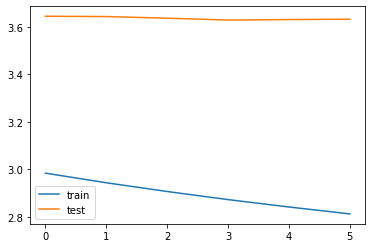

In [201]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<br>

## 인퍼런스 모델 구현하기

<br>

<br>

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 합니다. <br>
따라서 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

<br>

In [202]:
# 단어사전 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

<br>

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다릅니다. <br>
따라서 그에 맞게 모델 설계를 별개로 진행해야 합니다. <br><br>

- __학습 단계__ <br>
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비 <br><br>

- __인퍼런스 단계__ <br>
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

<br>

In [203]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

<br>

#### 어텐션 메커니즘을 사용하는 출력층 설계

<br>

In [204]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

<br>

#### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

<br>

In [205]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<br>

## 모델 테스트하기

<br>

<br>

### 정수 시퀀스 -> 텍스트 시퀀스 변환 <br><br>

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 필요합니다. <br>
이를 위해 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 작성하여 테스트를 해봅니다. <br><br>

Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 변환함수를 작성합니다.

<br>

In [206]:
# 모델 테스트를 위해 정수 시퀀스 -> 텍스트 시퀀스 변환 함수 작성

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

<br>

### 모델 테스트 (적용)

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

<br>

In [207]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : indian chinaman kuldeep yadav became first indian spinner take hat trick odi cricket achieving feat second odi australia thursday yadav took wickets matthew wade ashton agar pat cummins consecutive balls eighth first odi hat trick indian years 
실제 요약 : kuldeep becomes first indian spinner to take odi hat trick 
예측 요약 :  kuldeep st indian spinner to take hat trick in odi history


원문 : madhya pradesh police seized kg beef two men state damoh district thursday two persons later arrested allegedly carrying meat cow legs plastic bags car cops seized meat following tip right wing organisation thursday night 
실제 요약 : over kg beef seized in mp two arrested 
예측 요약 :  mp police arrest for kg of cow seized in mp


원문 : madhya pradesh police found nearly people listed school dropouts ages fudged district education department records allegedly increase enrolment numbers schools matter came light police launched initiative encourage government school dropouts study notably year old woman liste

<br>

### 결과 <br><br>

__워드 임베딩과 RNN의 콜라보__ <br><br>

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미있는 요약들이 보입니다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있습니다. <br><br>

그다지 좋지 않은 요약의 예도 꽤나 보이기도 합니다. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다.

<br>

<br>

## 추출적 요약 해보기

Abstraction Summarization <br><br>

앞서 seq2seq를 통해서 추상적 요약 을 진행했습니다. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있습니다.

<br>

<br>

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있습니다. <br>

```
$ pip install summa
```

<br>

In [86]:
# suma 모듈 임포트

import requests
from summa.summarizer import summarize

In [87]:
# 데이터 불러오기

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv")

print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [95]:
# 데이터 샘플 확인

"""
'text', 'headlines' 두 개의 칼럼으로 구성
Abstractive Summarization 의 경우 : text를 본문, headlines를 요약문 데이터로 사용
Extractive Summarization 의 경우 : text를 본문으로 하나만 데이터로 사용
"""

data_text = data['text']

data_text.head(10)

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

<br>

## summarize 사용하기

Summa의 summarize 는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다. <br>
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있습니다.

<br>

<br>

### Summa의 summarizer.summarize() <br><br>

인자 <br>
- text (str) : 요약할 테스트. <br>
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값 <br>
- words (int or None, optional) – 출력에 포함할 단어 수. <br>
( 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시 ) <br>
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환 <br>

<br>

In [208]:
txt = data_text[0]
print(txt)

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [214]:
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄입니다.

print('Summary:')
print(summarize(txt, ratio=0.75))

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [213]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 변경

print('Summary:')
print(summarize(txt, ratio=0.75, split=True))

Summary:
["The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.", "upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [216]:
# 단어의 수로 요약문의 크기를 조절

print('Summary:')
print(summarize(txt, words=30))    # 단어를 10개만 선택

Summary:
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


<br>

## 결론 <br><br>

### Abstractive Summarization <br>
추상적 요약에서는 본문 text에 포함되지 않더라도 연관된다고 생각할 수 있는 어휘들을 사용하여 좀 더 자유로운 문장으로 요약(summarization)을 진행하는 것을 확인할 수 있습니다. 하지만, 자유도가 높은 만큼 적절한 전처리가 이루어지지 않은 경우 모델을 잘 학습시키기 어려웠으며, 문장은 자연스러워도 의미가 달라진 요약문이 출력되는 경우가 생겼습니다. <br><br>

### Extractive Summarization <br>
추출적 요약에서는 본문 text에 포함되어 있는 어휘를 사용한 문장으로 요약(summarization)을 진행하는 것을 확인할 수 있습니다. 그렇기 때문에 비교적 본문의 내용에서 크게 벗어나지 않은 요약문이 출력되는 것을 확인할 수 있습니다. 하지만 표현의 자유도가 많이 떨어져서 '본문을 짧게 썼다' 정도의 요약문이 생성되는 것을 볼 수 있습니다.

<br>